In [2]:
import pickle
import mdtraj as md 

In [3]:
#lets load the parmed object and trajectories
with open('benzene_rdkit.pkl', 'rb') as f:
    benzene = pickle.load(f)
traj_rt = md.load('test.h5')
traj_350 = md.load('test_benzene_350K.h5')
traj_450 = md.load('test_benzene_450K.h5')

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [16]:
#make function to count number of molecules that in course of trajectory had at least one atom with z coordinate > 3
def count_molecules(traj):
    count = 0
    max_z_coord = 0
    min_z_coord = 1000
    for frame in traj.xyz:
        for atom in frame:
            if atom[2] > 2.8*2 and atom[2] < 2.8*4:
                count += 1
                break
    return count

#count molecules in each trajectory
count_rt = count_molecules(traj_rt)
count_350 = count_molecules(traj_350)
count_450 = count_molecules(traj_450)

#output results
print("Number of molecules with at least one atom with z coordinate > 3:")
print("Room temperature: ", count_rt)
print("350 K: ", count_350)
print("450 K: ", count_450)
print("Number of atoms in benzene: ", len(benzene.atoms))

Number of molecules with at least one atom with z coordinate > 3:
Room temperature:  2052
350 K:  4778
450 K:  4967
Number of molecules in benzene:  1200


100%|██████████| 5000/5000 [00:09<00:00, 554.12it/s]


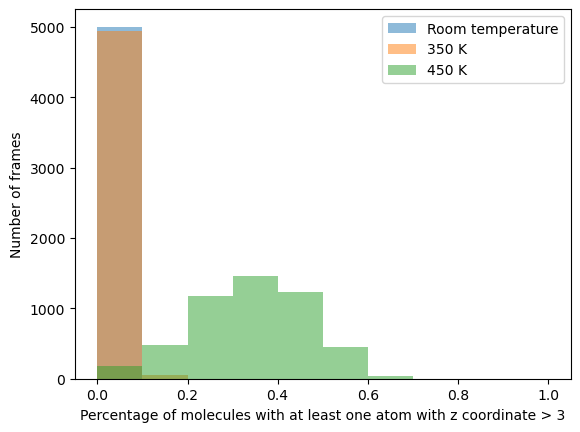

In [43]:
#get per frame, percentage of molecules in that ragnge, output list, plot histogram
from tqdm import tqdm
def get_percentage(traj):
    percentage = []
    for frame in tqdm(traj.xyz):
        count = 0
        for atom in frame:
            if atom[2] > 2.8*2 and atom[2] < 2.8*4:
                count += 1
        percentage.append(count/len(benzene.atoms))
    return percentage

percentage_rt = get_percentage(traj_rt)
percentage_350 = get_percentage(traj_350)
percentage_450 = get_percentage(traj_450)

import matplotlib.pyplot as plt
import numpy as np

plt.hist(percentage_rt, bins=np.arange(0, 1.1, 0.1), alpha=0.5, label='Room temperature')
plt.hist(percentage_350, bins=np.arange(0, 1.1, 0.1), alpha=0.5, label='350 K')
plt.hist(percentage_450, bins=np.arange(0, 1.1, 0.1), alpha=0.5, label='450 K')
plt.legend(loc='upper right')
plt.xlabel('Percentage of molecules with at least one atom with z coordinate > 3')
plt.ylabel('Number of frames')
plt.show()

In [45]:

#print mean for all
print("Mean percentage of molecules with at least one atom with z coordinate > 3:")
print("Room temperature: ", np.mean(percentage_rt) * 100)
print("350 K: ", np.mean(percentage_350) * 100)
print("450 K: ", np.mean(percentage_450) * 100)

Mean percentage of molecules with at least one atom with z coordinate > 3:
Room temperature:  0.45509999999999995
350 K:  4.139916666666667
450 K:  34.10501666666666


[2.56219577e+05 5.74065003e+05 1.00813370e+06 1.42485338e+06
 1.69381571e+06 1.82698047e+06 1.89513109e+06 1.94984755e+06
 1.96770939e+06 1.98638625e+06 1.98598331e+06 1.97138157e+06
 1.91358359e+06 1.79221835e+06 1.59502845e+06 1.29243953e+06
 9.08975556e+05 5.22457532e+05 2.42954840e+05 1.01662734e+05
 4.15707770e+04 1.80175138e+04 8.21891669e+03 6.02110053e+03
 6.38740322e+03 6.75828470e+03 6.09893985e+03 5.21523460e+03
 5.69142810e+03 6.30956390e+03 5.48080406e+03 4.41852624e+03
 4.34984449e+03 4.40478989e+03 3.98354179e+03 3.82786315e+03
 4.18042949e+03 4.99087420e+03 4.45515651e+03 3.60808153e+03
 3.70423599e+03 3.96522666e+03 3.97896301e+03 3.51192708e+03
 3.18683344e+03 3.09983655e+03 2.74269142e+03 2.22986765e+03
 1.97803455e+03 2.28023427e+03 2.13829197e+03 1.82235590e+03
 1.55220766e+03 1.44689564e+03 1.88188009e+03 1.79488320e+03
 2.10624049e+03 2.64653696e+03 2.53206737e+03 2.24818278e+03
 1.77656806e+03 2.02840117e+03 2.37638873e+03 2.81137317e+03
 3.13646682e+03 3.223463

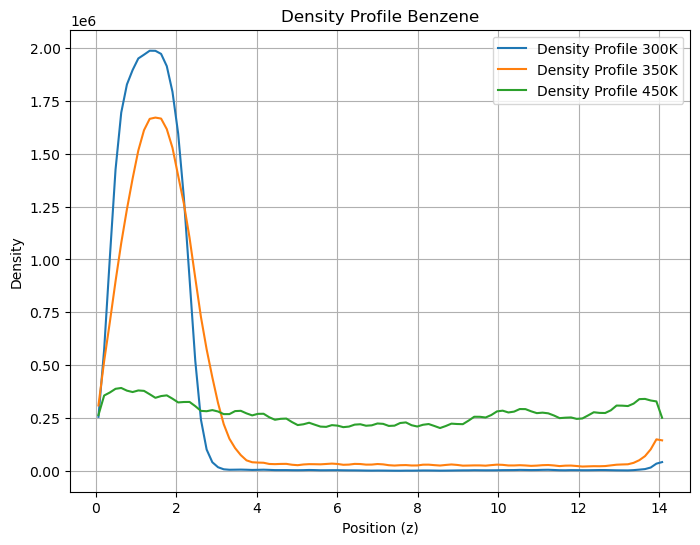

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from simtk.unit import nanometer


# Example function to calculate physical density profile
def calculate_physical_density_profile(trajectory, box_length, n_bins, molecular_weight, axis=2):
    """
    Calculate the physical density profile along a given axis.

    Parameters:
    trajectory : numpy.ndarray
        Array of shape (n_frames, n_particles, 3) containing particle positions.
    box_length : float
        Length of the simulation box along the axis of interest in Angstroms.
    n_bins : int
        Number of bins to divide the box length into.
    molecular_weight : float
        Molecular weight of the molecule in grams per mole (g/mol).
    axis : int
        Axis along which to calculate the density profile (0: x, 1: y, 2: z).

    Returns:
    bin_centers : numpy.ndarray
        Centers of the bins in Angstroms.
    density : numpy.ndarray
        Physical density values for each bin in g/cm³.
    """
    # Avogadro's number (particles per mole)
    avogadro_number = 6.02214076e23
    
    # Convert molecular weight to mass of one molecule in grams
    mass_per_molecule = molecular_weight / avogadro_number
    trajectory = trajectory.xyz
    # Get the positions along the specified axis
    positions = trajectory[:, :, axis].flatten()
    
    # Create histogram
    hist, bin_edges = np.histogram(positions, bins=n_bins, range=(0, box_length))
    
    # Calculate bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate bin volume in cubic centimeters (assuming 1 Å = 1e-8 cm)
    bin_volume = (box_length / n_bins) * (box_length * 1e-8)**2 * 1e-8
    
    # Calculate density in g/cm³
    density = (hist * mass_per_molecule) / bin_volume
    
    return bin_centers, density
from rdkit import Chem
from rdkit.Chem import Descriptors
smiles_benze = 'c1ccccc1'
benzene_mol = Chem.MolFromSmiles(smiles_benze)
molecular_weight = Descriptors.ExactMolWt(benzene_mol)
# Example data
n_bins = 100
box_length = benzene.box_vectors[2][2].value_in_unit(nanometer) * 5
bin_centers_RT, density_RT = calculate_physical_density_profile(traj_rt, box_length, n_bins, molecular_weight, axis=2)
bin_centers_350K, density_350K = calculate_physical_density_profile(traj_350, box_length, n_bins, molecular_weight, axis=2)
bin_centers_450K, density_450K = calculate_physical_density_profile(traj_450, box_length, n_bins, molecular_weight, axis=2)
print(density_RT)
# Plotting the density profile
plt.figure(figsize=(8, 6))
plt.plot(bin_centers_RT, density_RT, label='Density Profile 300K')
plt.plot(bin_centers_350K, density_350K, label='Density Profile 350K')
plt.plot(bin_centers_450K, density_450K, label='Density Profile 450K')
plt.xlabel('Position (z)')
plt.ylabel('Density')
plt.title('Density Profile Benzene')
plt.legend()
plt.grid(True)
plt.show()

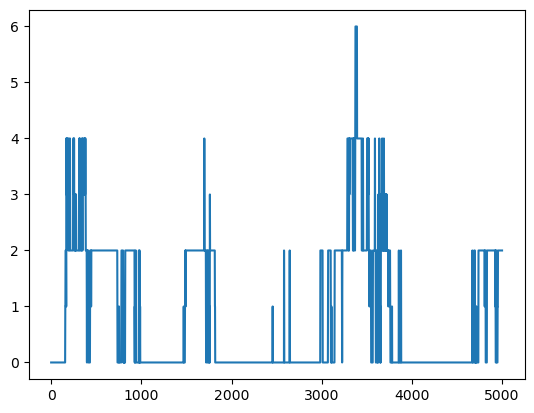

In [63]:
#get number of gas molecules at each frame
n_t = []

#add number of gas molecules at each frame to list
for frame in traj_rt.xyz:
    n = 0
    for atom in frame:
        if atom[2] > 2.8*2 and atom[2] < 2.8*4:
            n += 1
    n_t.append(n)

nm_t = [int(x/6) for x in n_t]
plt.plot(nm_t)



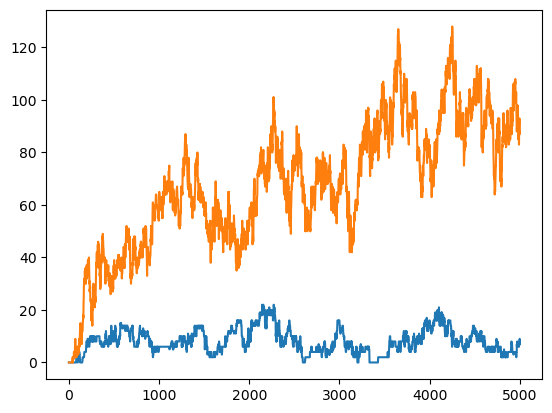

In [64]:
#repeat for 350 and 450 K
n_t_350 = []
n_t_450 = []

for frame in traj_350.xyz:
    n = 0
    for atom in frame:
        if atom[2] > 2.8*2 and atom[2] < 2.8*4:
            n += 1
    n_t_350.append(n)

for frame in traj_450.xyz:
    n = 0
    for atom in frame:
        if atom[2] > 2.8*2 and atom[2] < 2.8*4:
            n += 1
    n_t_450.append(n)

nm_t_350 = [int(x/6) for x in n_t_350]
nm_t_450 = [int(x/6) for x in n_t_450]

plt.plot(nm_t_350)
plt.plot(nm_t_450)
plt.show()


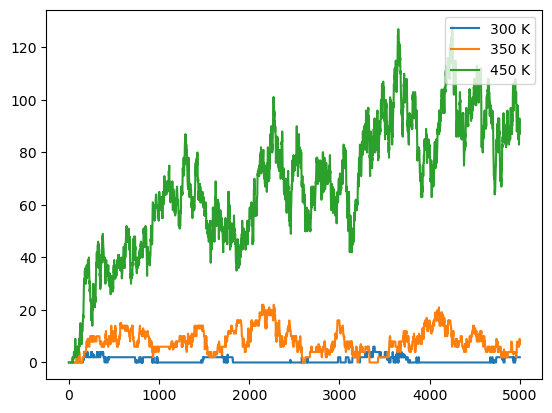

In [66]:
plt.plot(nm_t, label='300 K')
plt.plot(nm_t_350, label='350 K')
plt.plot(nm_t_450, label='450 K')
plt.legend(loc='upper right')
plt.show()

In [68]:
#get mean, std, and median of number of molecules in the vapor phase for each traj
print("Mean number of molecules in the vapor phase:")
print("300 K: ", np.mean(nm_t))
print("350 K: ", np.mean(nm_t_350))
print("450 K: ", np.mean(nm_t_450))

print("Standard deviation of number of molecules in the vapor phase:")
print("300 K: ", np.std(nm_t))
print("350 K: ", np.std(nm_t_350))
print("450 K: ", np.std(nm_t_450))

print("Median number of molecules in the vapor phase:")
print("300 K: ", np.median(nm_t))
print("350 K: ", np.median(nm_t_350))
print("450 K: ", np.median(nm_t_450))


Mean number of molecules in the vapor phase:
300 K:  0.874
350 K:  8.1046
450 K:  67.8116
Standard deviation of number of molecules in the vapor phase:
300 K:  1.2043770173828459
350 K:  4.609344730002302
450 K:  24.716369179958452
Median number of molecules in the vapor phase:
300 K:  0.0
350 K:  8.0
450 K:  68.0


In [70]:
import mdtraj as md


# Define the atom indices for the two molecules
# Assume molecule1_indices and molecule2_indices are lists of atom indices
# For example, you can use md.select to select atoms by residue name or index
molecule1_indices = benzene.topology.select('resname MOL1')
molecule2_indices = benzene.topology.select('resname MOL2')

# Calculate the minimum distance between the two sets of atoms
min_distances = md.compute_neighbors(traj_rt, 0.5, molecule1_indices, haystack_indices=molecule2_indices)

# If you want the minimum distance for each frame
min_distances_per_frame = [min([md.compute_distances(traj_rt[i], [pair])[0] for pair in pairs]) for i, pairs in enumerate(min_distances)]

# Print the minimum distances
for i, dist in enumerate(min_distances_per_frame):
    print(f"Frame {i}: {dist:.2f} nm")

AttributeError: 'Topology' object has no attribute 'select'

In [85]:
residues = [res for res in benzene.topology.residues()]
atoms_res0 = [atom for atom in residues[0].atoms()]
atoms_res0

[<Atom 0 (C1) of chain 0 residue 0 (DIU)>,
 <Atom 1 (C2) of chain 0 residue 0 (DIU)>,
 <Atom 2 (C3) of chain 0 residue 0 (DIU)>,
 <Atom 3 (C4) of chain 0 residue 0 (DIU)>,
 <Atom 4 (C5) of chain 0 residue 0 (DIU)>,
 <Atom 5 (C6) of chain 0 residue 0 (DIU)>,
 <Atom 6 (H1) of chain 0 residue 0 (DIU)>,
 <Atom 7 (H2) of chain 0 residue 0 (DIU)>,
 <Atom 8 (H3) of chain 0 residue 0 (DIU)>,
 <Atom 9 (H4) of chain 0 residue 0 (DIU)>,
 <Atom 10 (H5) of chain 0 residue 0 (DIU)>,
 <Atom 11 (H6) of chain 0 residue 0 (DIU)>]

In [86]:
atom_indices = [atom.index for atom in atoms_res0]
atom_indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [87]:
neighbours = md.compute_neighbors(traj_rt, 0.5, atom_indices)

In [92]:
#mdtraj.compute_rdf(traj, pairs, r_range=None, bin_width=0.005, n_bins=None, periodic=True, opt=True)
#use this function to calculate rdf
#pairs is a list of tuples of atom indices for which to calculate the rdf
#r_range is the range of distances to calculate the rdf
#bin_width is the width of each bin in the histogram
#n_bins is the number of bins in the histogram
#periodic is a boolean indicating whether the system is periodic
#opt is a boolean indicating whether to
#use optimized code for calculating the rdf

#do all pairs
pairs = [(i, j) for i in range(len(benzene.atoms)) for j in range(i+1, len(benzene.atoms))]
r_range = (0, 1)
bin_width = 0.01
n_bins = 100
periodic = True
opt = True

rdf = md.compute_rdf(traj_rt, pairs, r_range=r_range, bin_width=bin_width, n_bins=n_bins, periodic=periodic, opt=opt)

KeyboardInterrupt: 

In [167]:
benzene.box_vectors[2][2].value_in_unit(nanometer)

2.8291000000000004

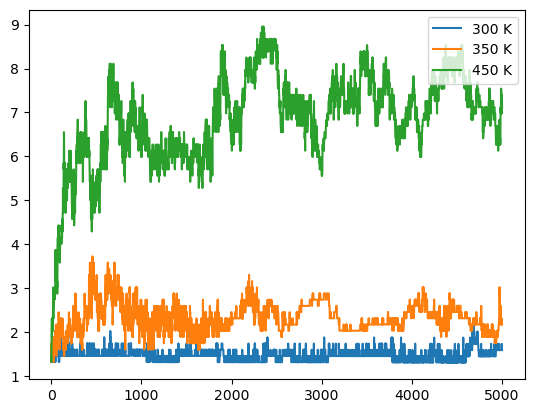

Mean z value:
300 K:  0.5190839795656075
350 K:  0.8209359913878372
450 K:  2.4196806470455057


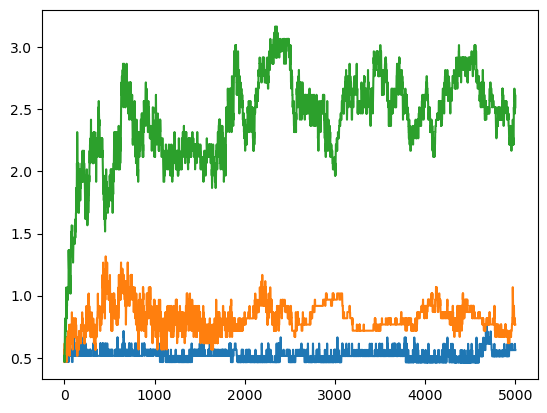

In [170]:
com_rt = md.compute_center_of_mass(traj_rt)
com_350 = md.compute_center_of_mass(traj_350)
com_450 = md.compute_center_of_mass(traj_450)
#plot the z values
com_z_rt = [com[2] for com in com_rt]
com_z_350 = [com[2] for com in com_350]
com_z_450 = [com[2] for com in com_450]

plt.plot(com_z_rt, label='300 K')
plt.plot(com_z_350, label='350 K')
plt.plot(com_z_450, label='450 K')
plt.legend(loc='upper right')
plt.show()

#now sampe plot, but normalize by box length
com_z_rt_norm = [com[2] / benzene.box_vectors[2][2].value_in_unit(nanometer) for com in com_rt]
com_z_350_norm = [com[2] / benzene.box_vectors[2][2].value_in_unit(nanometer) for com in com_350]
com_z_450_norm = [com[2] / benzene.box_vectors[2][2].value_in_unit(nanometer) for com in com_450]

plt.plot(com_z_rt_norm, label='300 K')
plt.plot(com_z_350_norm, label='350 K')
plt.plot(com_z_450_norm, label='450 K')
#print mean 
print("Mean z value:")
print("300 K: ", np.mean(com_z_rt_norm))
print("350 K: ", np.mean(com_z_350_norm))
print("450 K: ", np.mean(com_z_450_norm))

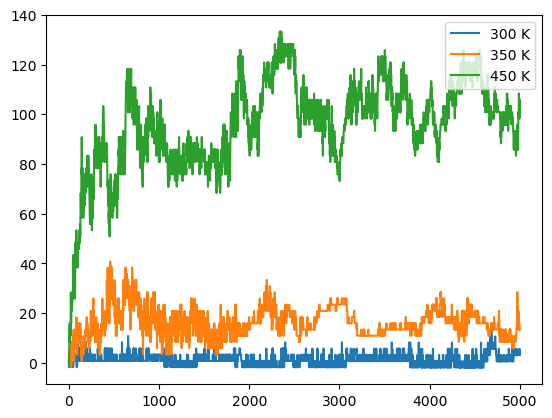

Mean normalized z value:
300 K:  0.9541989782803799
350 K:  16.046799569391855
450 K:  95.98403235227529


In [171]:
def custom_normalize(values, box_len, num_boxes):
    expected_max = (box_len * num_boxes) / 2
    expected_min = box_len / 2
    
    # Normalize to [0, 1] range
    normalized_values = [
        (value - expected_min) / (expected_max - expected_min)
        for value in values
    ]
    
    # Scale to [0, 100] range
    scaled_values = [value * 100 for value in normalized_values]
    
    return scaled_values

# Normalize the center of mass values
com_z_rt_scaled = custom_normalize(com_z_rt, benzene.box_vectors[2][2].value_in_unit(nanometer), 5)
com_z_350_scaled = custom_normalize(com_z_350, benzene.box_vectors[2][2].value_in_unit(nanometer), 5)
com_z_450_scaled = custom_normalize(com_z_450, benzene.box_vectors[2][2].value_in_unit(nanometer), 5)

plt.plot(com_z_rt_scaled, label='300 K')
plt.plot(com_z_350_scaled, label='350 K')
plt.plot(com_z_450_scaled, label='450 K')
plt.legend(loc='upper right')
plt.show()

#calculate the mean and standard deviation of the normalized values
print("Mean normalized z value:")
print("300 K: ", np.mean(com_z_rt_scaled))
print("350 K: ", np.mean(com_z_350_scaled))
print("450 K: ", np.mean(com_z_450_scaled))

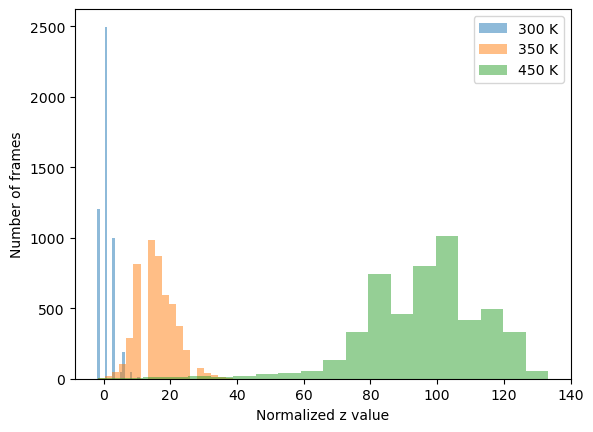

Mean normalized z value:
300 K:  0.9541989782803799
350 K:  16.046799569391855
450 K:  95.98403235227529
Standard deviation of normalized z value:
300 K:  2.153111096159981
350 K:  5.670516929145997
450 K:  18.04155785640113


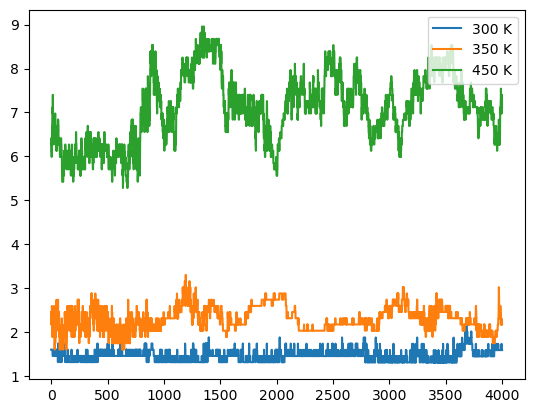

Mean z value:
300 K:  0.5147399964426083
350 K:  0.8119254897883609
450 K:  2.5076825967988716


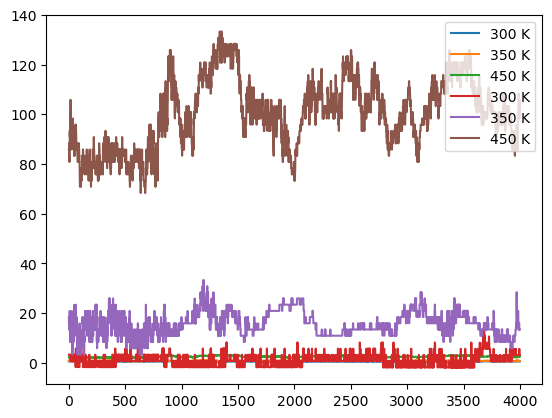

Mean normalized z value:
300 K:  0.7369998221304118
350 K:  15.596274489418043
450 K:  100.38412983994358


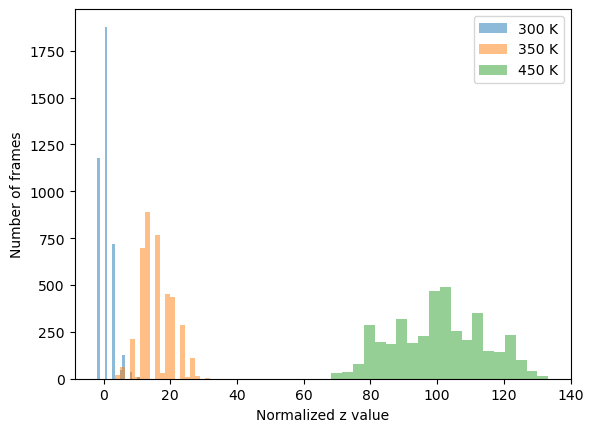

In [175]:
#plot histograms of the normalized values
plt.hist(com_z_rt_scaled, bins=20, alpha=0.5, label='300 K')
plt.hist(com_z_350_scaled, bins=20, alpha=0.5, label='350 K')
plt.hist(com_z_450_scaled, bins=20, alpha=0.5, label='450 K')
plt.legend(loc='upper right')
plt.xlabel('Normalized z value')
plt.ylabel('Number of frames')
plt.show()
#get mean and std of the normalized values
print("Mean normalized z value:")
print("300 K: ", np.mean(com_z_rt_scaled))
print("350 K: ", np.mean(com_z_350_scaled))
print("450 K: ", np.mean(com_z_450_scaled))

print("Standard deviation of normalized z value:")
print("300 K: ", np.std(com_z_rt_scaled))
print("350 K: ", np.std(com_z_350_scaled))
print("450 K: ", np.std(com_z_450_scaled))

#do same but discard first 1000 frames
com_rt = md.compute_center_of_mass(traj_rt[1000:])
com_350 = md.compute_center_of_mass(traj_350[1000:])
com_450 = md.compute_center_of_mass(traj_450[1000:])
#plot the z values
com_z_rt = [com[2] for com in com_rt]
com_z_350 = [com[2] for com in com_350]
com_z_450 = [com[2] for com in com_450]

plt.plot(com_z_rt, label='300 K')
plt.plot(com_z_350, label='350 K')
plt.plot(com_z_450, label='450 K')
plt.legend(loc='upper right')
plt.show()

#now sampe plot, but normalize by box length
com_z_rt_norm = [com[2] / benzene.box_vectors[2][2].value_in_unit(nanometer) for com in com_rt]
com_z_350_norm = [com[2] / benzene.box_vectors[2][2].value_in_unit(nanometer) for com in com_350]
com_z_450_norm = [com[2] / benzene.box_vectors[2][2].value_in_unit(nanometer) for com in com_450]

plt.plot(com_z_rt_norm, label='300 K')
plt.plot(com_z_350_norm, label='350 K')
plt.plot(com_z_450_norm, label='450 K')
#print mean
print("Mean z value:")
print("300 K: ", np.mean(com_z_rt_norm))
print("350 K: ", np.mean(com_z_350_norm))
print("450 K: ", np.mean(com_z_450_norm))

# Normalize the center of mass values
com_z_rt_scaled = custom_normalize(com_z_rt, benzene.box_vectors[2][2].value_in_unit(nanometer), 5)
com_z_350_scaled = custom_normalize(com_z_350, benzene.box_vectors[2][2].value_in_unit(nanometer), 5)
com_z_450_scaled = custom_normalize(com_z_450, benzene.box_vectors[2][2].value_in_unit(nanometer), 5)

plt.plot(com_z_rt_scaled, label='300 K')
plt.plot(com_z_350_scaled, label='350 K')
plt.plot(com_z_450_scaled, label='450 K')
plt.legend(loc='upper right')
plt.show()

#calculate the mean and standard deviation of the normalized values
print("Mean normalized z value:")
print("300 K: ", np.mean(com_z_rt_scaled))
print("350 K: ", np.mean(com_z_350_scaled))
print("450 K: ", np.mean(com_z_450_scaled))

#plot histograms of the normalized values
plt.hist(com_z_rt_scaled, bins=20, alpha=0.5, label='300 K')
plt.hist(com_z_350_scaled, bins=20, alpha=0.5, label='350 K')
plt.hist(com_z_450_scaled, bins=20, alpha=0.5, label='450 K')
plt.legend(loc='upper right')
plt.xlabel('Normalized z value')
plt.ylabel('Number of frames')

plt.show()



In [96]:
contatcs_rt = md.compute_contacts(traj_rt, contacts='all', scheme='closest-heavy',ignore_nonprotein=False,periodic=True)
contatcs_rt

(array([[1.0132633 , 0.40632406, 0.3633518 , ..., 2.1465175 , 1.3036057 ,
         0.6046596 ],
        [0.8856117 , 0.35336703, 0.31474376, ..., 1.9158827 , 1.3987707 ,
         0.5510183 ],
        [0.97448456, 0.3920466 , 0.37692088, ..., 1.7056957 , 1.5162979 ,
         0.439256  ],
        ...,
        [1.1508844 , 1.613885  , 0.33870742, ..., 0.72175676, 0.78210574,
         1.3063657 ],
        [1.0068641 , 1.5280033 , 0.41622192, ..., 0.6185674 , 0.69852656,
         1.4095572 ],
        [0.9993915 , 1.4441428 , 0.43192303, ..., 0.6770805 , 0.69806975,
         1.2911688 ]], dtype=float32),
 array([[ 0,  3],
        [ 0,  4],
        [ 0,  5],
        ...,
        [95, 98],
        [95, 99],
        [96, 99]]))

In [132]:
print(len(contatcs_rt),len(contatcs_rt[0]),len(contatcs_rt[0][0]))

2 5000 4753


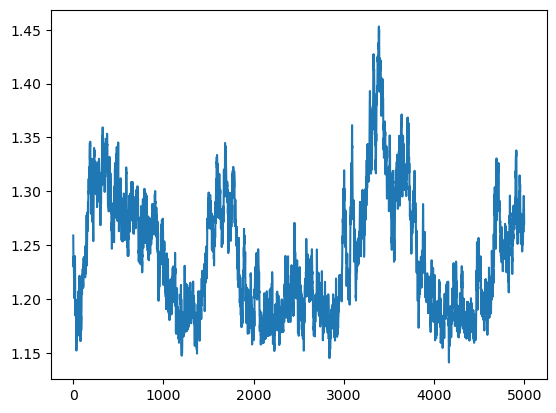

In [110]:

distances_array = contatcs_rt[0]
avg_distance_per_frame = np.mean(distances_array, axis=1)
plt.plot(avg_distance_per_frame)

In [111]:
# contatcs_rt = md.compute_contacts(traj_rt, contacts='all', scheme='closest-heavy',ignore_nonprotein=False,periodic=True)
# distances_array = contatcs_rt[0]
# avg_distance_per_frame = np.mean(distances_array, axis=1)
contatcs_350 = md.compute_contacts(traj_350, contacts='all', scheme='closest-heavy',ignore_nonprotein=False,periodic=True)
distances_array_350 = contatcs_350[0]
avg_distance_per_frame_350 = np.mean(distances_array_350, axis=1)

contatcs_450 = md.compute_contacts(traj_450, contacts='all', scheme='closest-heavy',ignore_nonprotein=False,periodic=True)
distances_array_450 = contatcs_450[0]
avg_distance_per_frame_450 = np.mean(distances_array_450, axis=1)


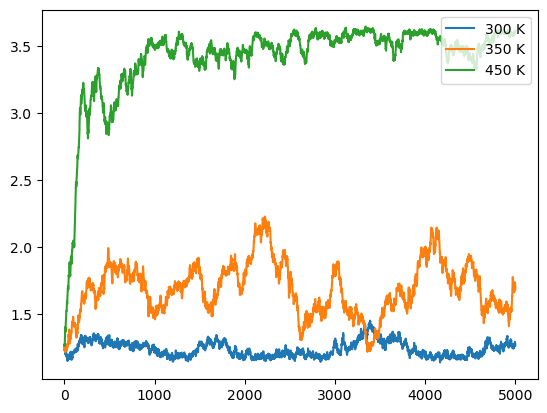

In [112]:
#plot all together
plt.plot(avg_distance_per_frame, label='300 K')
plt.plot(avg_distance_per_frame_350, label='350 K')
plt.plot(avg_distance_per_frame_450, label='450 K')
plt.legend(loc='upper right')
plt.show()


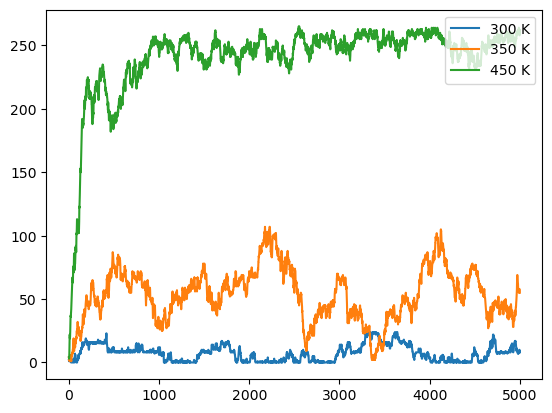

In [121]:
#also get number of distances per frame that are more then 1.5 nm
n_contacts_rt = [np.sum(distances > 2.5) for distances in distances_array]
n_contacts_350 = [np.sum(distances > 2.5) for distances in distances_array_350]
n_contacts_450 = [np.sum(distances > 2.5) for distances in distances_array_450]
n_contacts_rt_mol = [int(x/12) for x in n_contacts_rt]
n_contacts_350_mol = [int(x/12) for x in n_contacts_350]
n_contacts_450_mol = [int(x/12) for x in n_contacts_450]

plt.plot(n_contacts_rt_mol, label='300 K')
plt.plot(n_contacts_350_mol, label='350 K')
plt.plot(n_contacts_450_mol, label='450 K')
plt.legend(loc='upper right')
plt.show()


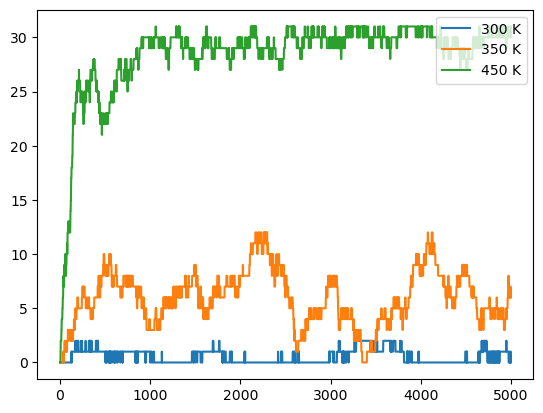

In [156]:
#also get number of distances per frame that are more then 1.5 nm
n_contacts_rt = [len(np.where(distances > 2.5)[0]) for distances in distances_array]
n_contacts_350 = [len(np.where(distances > 2.5)[0]) for distances in distances_array_350]
n_contacts_450 = [len(np.where(distances > 2.5)[0]) for distances in distances_array_450]

n_contacts_rt_mol = [int(x/12) for x in n_contacts_rt]
n_contacts_350_mol = [int(x/12) for x in n_contacts_350]
n_contacts_450_mol = [int(x/12) for x in n_contacts_450]

plt.plot(n_contacts_rt_mol, label='300 K')
plt.plot(n_contacts_350_mol, label='350 K')
plt.plot(n_contacts_450_mol, label='450 K')
plt.legend(loc='upper right')
plt.show()


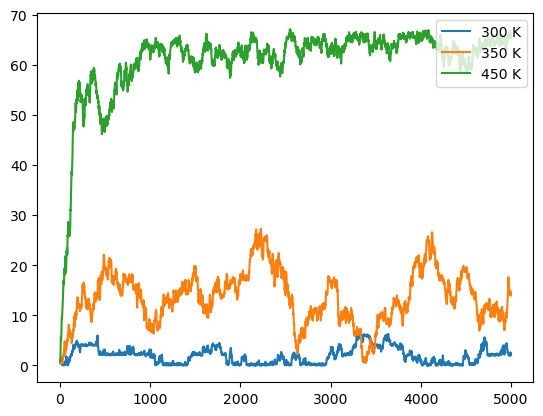

In [127]:
#do percentage instead
n_contacts_rt = [len(np.where(distances > 2.5)[0])/len(distances)*100 for distances in distances_array]
n_contacts_350 = [len(np.where(distances > 2.5)[0])/len(distances)*100 for distances in distances_array_350]
n_contacts_450 = [len(np.where(distances > 2.5)[0])/len(distances)*100 for distances in distances_array_450]

plt.plot(n_contacts_rt, label='300 K')
plt.plot(n_contacts_350, label='350 K')
plt.plot(n_contacts_450, label='450 K')
plt.legend(loc='upper right')

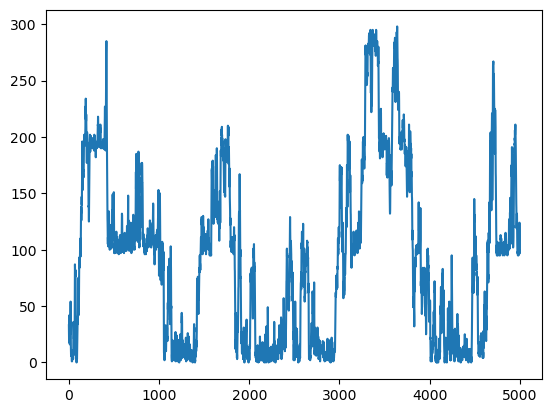

In [138]:
len(distances_array),len(distances_array[0])
l = []
for frame in distances_array:
    n_dists_above_2_5 = len(np.where(frame > 2.5)[0])
    l.append(n_dists_above_2_5)
plt.plot(l)

In [145]:
len(distances_array[2])
#this consist of 4753 pairs of atoms. 

4753

In [ ]:
distances_array

In [146]:
contatcs_rt

(array([[1.0132633 , 0.40632406, 0.3633518 , ..., 2.1465175 , 1.3036057 ,
         0.6046596 ],
        [0.8856117 , 0.35336703, 0.31474376, ..., 1.9158827 , 1.3987707 ,
         0.5510183 ],
        [0.97448456, 0.3920466 , 0.37692088, ..., 1.7056957 , 1.5162979 ,
         0.439256  ],
        ...,
        [1.1508844 , 1.613885  , 0.33870742, ..., 0.72175676, 0.78210574,
         1.3063657 ],
        [1.0068641 , 1.5280033 , 0.41622192, ..., 0.6185674 , 0.69852656,
         1.4095572 ],
        [0.9993915 , 1.4441428 , 0.43192303, ..., 0.6770805 , 0.69806975,
         1.2911688 ]], dtype=float32),
 array([[ 0,  3],
        [ 0,  4],
        [ 0,  5],
        ...,
        [95, 98],
        [95, 99],
        [96, 99]]))

In [155]:
import numpy as np
def count_frames_exceeding_threshold(contacts_rt, threshold=1.5):
    distances, residue_pairs = contacts_rt
    
    # Number of frames
    n_frames = distances.shape[0]
    # Number of residue pairs
    n_pairs = distances.shape[1]

    # Initialize a counter for each residue pair
    counters = np.zeros(n_pairs, dtype=int)
    
    # Iterate over each residue pair
    for pair_idx in range(n_pairs):
        # Initialize a counter for the current pair
        count = 0
        # Iterate over each frame
        for frame_idx in range(n_frames):
            # Get the distance for this pair in this frame
            distance = distances[frame_idx, pair_idx]
            # Check if the distance exceeds the threshold
            if distance > threshold:
                count += 1
        # Store the count for this pair
        counters[pair_idx] = count
    
    return counters
threshold = 0.5
result = count_frames_exceeding_threshold(contatcs_rt, threshold)
print(result)
#plot results
plt.plot(result)


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_754145/3702351672.py", line 29, in <module>
    result = count_frames_exceeding_threshold(contatcs_rt, threshold)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_754145/3702351672.py", line -1, in count_frames_exceeding_threshold
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/IPython/core/ultratb.

(array([339., 649., 521., 499., 503., 485., 468., 451., 462., 376.]),
 array([0.33070785, 1.00851738, 1.68632686, 2.36413622, 3.04194593,
        3.71975541, 4.39756489, 5.07537413, 5.75318384, 6.43099308,
        7.1088028 ]),
 <BarContainer object of 10 artists>)

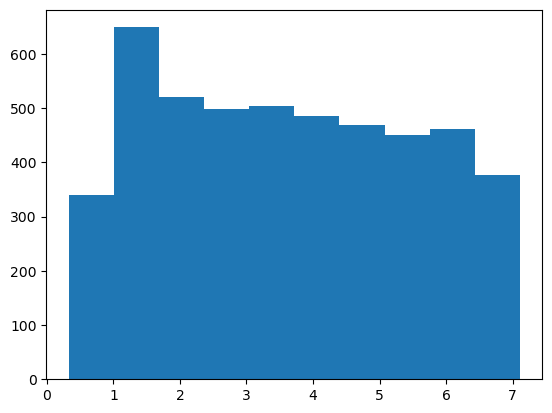

In [162]:
distances_array_450[-1]
#plot this as histogram
plt.hist(distances_array_450[-1], bins=10)